In [42]:
import sys
sys.path.append("../code")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scale_bar import add_scalebar
#plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.preamble'] = [r'\usepackage{lmodern}']

from sklearn.metrics.pairwise import euclidean_distances
from scipy import optimize

from scipy.io import savemat

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)

from sklearn.datasets import make_moons

from scipy.spatial import procrustes

dataset = 2
import mnist_reader 
    
X_train, y_train = mnist_reader.load_mnist('../data/mnist', kind='train')
X_test, y_test = mnist_reader.load_mnist('../data/mnist', kind='t10k')

#n = 2000
#np.random.seed(6333)
#ids = np.random.choice(range(60000),n, replace=False)
#X_train, y_train = X_train[ids], y_train[ids]

X_train = X_train.astype(np.float32)
max_val = np.max(X_train)
X_train = X_train/max_val

X_test = X_test/max_val

n = X_train.shape[0]

classes = [
    '0',
    '1',
    '2',
    '3',
    '4',
    '5',
    '6',
    '7',
    '8',
    '9']

print(X_train.shape, y_train.shape, X_train.dtype)

#Torch Setups
from sklearn.decomposition import PCA

#import torch
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#X_torch = torch.as_tensor(X_train, dtype=torch.float32, device=device)

n_components = 2

pca = PCA(n_components = n_components)
x_init = pca.fit_transform(X_train)
x_init = x_init - np.mean(x_init, axis=0)

def print_stats(X):
    print('size: ', X.shape)
    print('Mean:', np.mean(X))
    print('Max: ', np.max(X))
    print('Min: ', np.min(X))
    print('STD: ', np.std(X))
    
    return

print('Training Statistics')
print_stats(X_train)
#print('Test Statistics')
#print_stats(X_test)


epochs = 200
n_neighbors= 15
n_components = 2
MIN_DIST = 0.1

    
%matplotlib notebook
%matplotlib notebook

%load_ext autoreload
%autoreload 2

(60000, 784) (60000,) float32
Training Statistics
size:  (60000, 784)
Mean: 0.13066062
Max:  1.0
Min:  0.0
STD:  0.30810776
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from scale_bar import add_scalebar
from scipy.spatial import procrustes
from scipy.linalg import orthogonal_procrustes
from matplotlib.offsetbox import HPacker, TextArea

def plot_idxs(array,idxs,title=None, values = None, tick_off=True):
    
    plt.figure()
    
    if title is not None:
        plt.title(title)
        
    n_plot = int(np.sqrt(len(idxs)))
    
    for i in range(n_plot**2):
        ax = plt.subplot(n_plot, n_plot, i+1)
        plt.scatter(array[idxs[i],:,0], array[idxs[i],:,1], c=y_train, s=0.01, cmap='Spectral')
        add_scalebar(ax, loc=4, barwidth=1, matchx=False, matchy=False, 
                     sizey=1, sizex=1, 
                     labelx='1.0', labely='1.0',
                    fontsize='xx-small',
                    hidex=True, hidey=True)
        
        
        if values is not None:
            val = r"$p_d=${:.3f}".format(values[i])
            plt.text(1.0, 1.0, val,
                     horizontalalignment='right',
                     verticalalignment='top',
                     transform = ax.transAxes)
        if tick_off:
            plt.xticks([])
            plt.yticks([])
        plt.axis('on')
        
    return

def plot_low_k_idxs(array, metric, k, title=None):

    idxs_arg = np.argpartition(metric, k)[:k]
    values = metric[idxs_arg]

    idxs_arg_pointer = np.argsort(values)

    values = values[idxs_arg_pointer]
    idxs_arg = idxs_arg[idxs_arg_pointer]

    plot_idxs(array, idxs_arg, title=title, values=values)
    
    return

def plot_high_k_idxs(array, metric, k, title=None):

    idxs_arg = np.argpartition(metric, -k)[-k:]
    values = metric[idxs_arg]

    idxs_arg_pointer = np.argsort(values)

    values = values[idxs_arg_pointer]
    idxs_arg = idxs_arg[idxs_arg_pointer]

    plot_idxs(array, idxs_arg, title=title, values=values)
    
    return

def my_procrustes(data1, data2):
    #adapted from https://github.com/scipy/scipy/blob/v1.11.2/scipy/spatial/_procrustes.py#L15-L131
    mtx1 = np.array(data1, dtype=np.double, copy=True)
    mtx2 = np.array(data2, dtype=np.double, copy=True)
    
    
    mtx1 -= np.mean(mtx1, 0)
    mtx2 -= np.mean(mtx2, 0)

    norm1 = np.linalg.norm(mtx1)
    norm2 = np.linalg.norm(mtx2)
    
    mtx1 /= norm1
    mtx2 /= norm2
    
    R, s = orthogonal_procrustes(mtx1, mtx2)
    mtx2 = np.dot(mtx2, R.T) * s
    
    disparity = np.sum(np.square(mtx1 - mtx2))
    
    mtx2 = np.dot(data2, R.T) #just get the rotation, reflection - and no scaling
    
    
    return disparity, mtx2

def procrustes_distances(standard_array, array, verbose=True): 
    pds = []
    X_pdx = []

    for i in range(len(array)):
        d,x_pd = my_procrustes(standard_array, array[i])
        pds.append(d)
        X_pdx.append(x_pd)

    pds = np.array(pds)
    X_pdx = np.array(X_pdx)
    if verbose:
        print('Procrusted Distance: Mean: ', np.mean(pds), ' STD: ', np.std(pds))
    
    return pds, X_pdx

def procrustes_matrix(standard_array, array):
    diagonal, X_pdx = procrustes_distances(standard_array, array)
    
    N = len(array)
    pd_mat = np.zeros((N,N))
    
    for i in range(N):
        row, _ = procrustes_distances(array[i], array, verbose=False)
        pd_mat[i,:] = row
    
    #print(np.diag(pd_mat))
    
    for i in range(N):
        pd_mat[i,i] = diagonal[i]
        
    return pd_mat, X_pdx

def pdmat_similarity(pd_mat):
    pd_mat_3 = pd_mat.copy()
    np.fill_diagonal(pd_mat_3, 0)
    z = pd_mat_3[pd_mat_3>0]
    return np.mean(z), np.std(z)
#print('Original UMAP: ', np.mean(z), np.std(z))

In [30]:
fig_folder = 'PaCMAP_Figs/'

with open('pacmap_candle.npy', 'rb') as f:
    umap_pca = np.load(f)
    
print(umap_pca.shape)



(60000, 2)


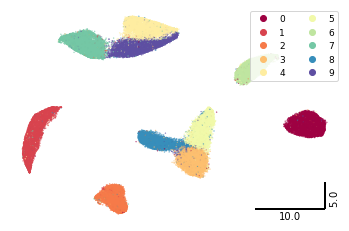

In [34]:
fig, ax = plt.subplots()

scatter = plt.scatter(umap_pca[:,0], umap_pca[:,1], c=y_train, s=0.1, alpha=1.0, cmap='Spectral')
plt.axis('off')

add_scalebar(ax, loc=4, barwidth=2)

lgd = plt.legend(*scatter.legend_elements(),
                    loc="upper right",
                    fontsize=20,
                 ncol=2,
                prop={'size': 9})
for j in range(len(lgd.get_texts())):
    lgd.get_texts()[j].set_text(classes[j])
    
#plt.title('PacMAP (PCA init)')
    
plt.savefig(fig_folder+'standard_pacmap_candle.png', dpi=400, bbox_inches='tight', pad_inches=0.4)

<h1> Original PaCMAP</h1>

In [6]:
with open('pacmap_random.npy', 'rb') as f:
    umap_r1 = np.load(f)
    
print(umap_r1.shape)

pd_r1, umap_pd_r1 = procrustes_distances(umap_pca, umap_r1)

print(umap_pd_r1.shape)

pd_mat, X_pdx = procrustes_matrix(umap_pca, umap_r1)

(100, 60000, 2)
Procrusted Distance: Mean:  0.38067764546586136  STD:  0.22867941682331278
(100, 60000, 2)
Procrusted Distance: Mean:  0.38067764546586136  STD:  0.22867941682331278


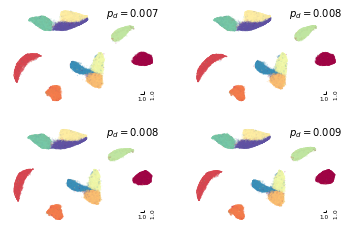

In [33]:
plot_low_k_idxs(umap_pd_r1,pd_r1,4)
plt.savefig(fig_folder+'trimap_random.png', dpi=400, bbox_inches='tight', pad_inches=0.4)
#plt.title('Randomly Init')

original: (0.5061039262429765, 0.21979802219368616)
[0.00681601 0.0076839  0.0079193  0.00872493 0.00912386 0.01502706
 0.01649734 0.02549401 0.02843692 0.02965024 0.03031647 0.0376758
 0.03827335 0.03855925 0.04914889 0.06050764 0.12023799 0.13159301
 0.13558887 0.15983863 0.16355229 0.163707   0.17938929 0.2274192
 0.22883985 0.23950683 0.24303842 0.25566648 0.26228158 0.26692932
 0.26856955 0.2717233  0.27223079 0.27596879 0.277122   0.27907067
 0.28043244 0.28167788 0.29168044 0.29749486 0.3060561  0.31332669
 0.31562319 0.320529   0.32253275 0.3244358  0.3351894  0.34931694
 0.35357249 0.36234435 0.36640876 0.37296167 0.37314176 0.37339129
 0.39527398 0.39621044 0.39915885 0.40708461 0.42062549 0.42748111
 0.43937198 0.44266241 0.4610758  0.46776874 0.49109583 0.54575314
 0.56996687 0.58665133 0.58672674 0.58684351 0.58826804 0.58830408
 0.59402395 0.59478017 0.59859823 0.60167542 0.60635691 0.60726946
 0.612594   0.61418626 0.62272208 0.62578921 0.63143031 0.63598435
 0.65088667 

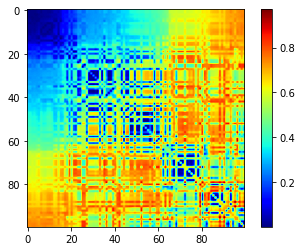

In [8]:
idx = np.argsort(np.diag(pd_mat))
pd_mat_2 = pd_mat[idx,:][:,idx]

print('original:', pdmat_similarity(pd_mat_2))

plt.figure()
plt.imshow(pd_mat_2, cmap='jet')
plt.colorbar()

print(np.diag(pd_mat_2))

<h1>PaCMAP Modified</h1>

In [21]:
with open('pacmap_modified_random_0.001.npy', 'rb') as f:
    umap_mod = np.load(f)
    
print(umap_mod.shape)

pd_mod, umap_pd_mod = procrustes_distances(umap_pca, umap_mod)

print(umap_pd_mod.shape)

pd_mat_mod, X_pdx_mod = procrustes_matrix(umap_pca, umap_mod)

(100, 60000, 2)
Procrusted Distance: Mean:  0.33384756080527966  STD:  0.17705812301937132
(100, 60000, 2)
Procrusted Distance: Mean:  0.33384756080527966  STD:  0.17705812301937132


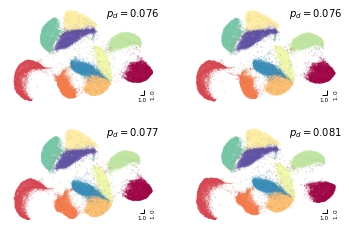

In [22]:
plot_low_k_idxs(umap_pd_mod,pd_mod,4)

plt.savefig(fig_folder+'trimap_mod_random.png', dpi=400, bbox_inches='tight', pad_inches=0.4)

modified: (0.4250562933897104, 0.2167271768823852)


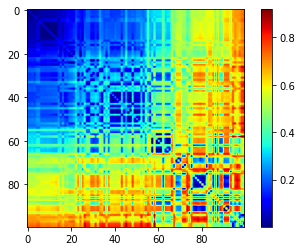

In [23]:
idx_mod = np.argsort(np.diag(pd_mat_mod))
pd_mat_2_mod = pd_mat_mod[idx_mod,:][:,idx_mod]

print('modified:', pdmat_similarity(pd_mat_2_mod))

plt.figure()
plt.imshow(pd_mat_2_mod, cmap='jet')
plt.colorbar()

In [27]:
cmap = plt.cm.jet
norm = plt.Normalize(vmin=0, vmax=1)

pd_mat_2_mod_image = cmap(norm(pd_mat_2))
plt.imsave(fig_folder+'PD_pacmap_orig.eps', pd_mat_2_mod_image, dpi=300)

pd_mat_2_mod_image = cmap(norm(pd_mat_2_mod))
plt.imsave(fig_folder+'PD_pacmap_mod.eps', pd_mat_2_mod_image, dpi=300)


(60000, 2)


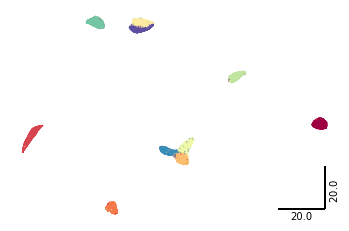

In [28]:
fig_folder = 'PaCMAP_Figs/'

with open('pacmap_repulsion.npy', 'rb') as f:
    umap_pca = np.load(f)
    
print(umap_pca.shape)

fig, ax = plt.subplots()

scatter = plt.scatter(umap_pca[:,0], umap_pca[:,1], c=y_train, s=0.1, alpha=1.0, cmap='Spectral')
plt.axis('off')

add_scalebar(ax, loc=4, barwidth=2)
    
plt.savefig(fig_folder+'pacmap_repulsion.png', dpi=400, bbox_inches='tight', pad_inches=0.4)

(60000, 2)


<IPython.core.display.Javascript object>


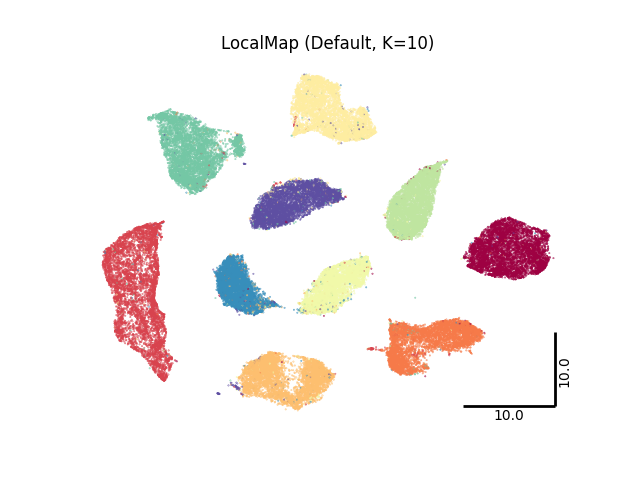

In [49]:
fig_folder = 'PaCMAP_Figs/'

with open('localmap_candle.npy', 'rb') as f:
    umap_pca = np.load(f)
    
print(umap_pca.shape)

fig, ax = plt.subplots()

scatter = plt.scatter(umap_pca[:,0], umap_pca[:,1], c=y_train, s=0.1, alpha=1.0, cmap='Spectral')
plt.axis('off')

add_scalebar(ax, loc=4, barwidth=2)
plt.title('LocalMap (Default, K=10)')
plt.savefig(fig_folder+'localmap_candle.png', dpi=400, bbox_inches='tight', pad_inches=0.4)

(60000, 2)


<IPython.core.display.Javascript object>


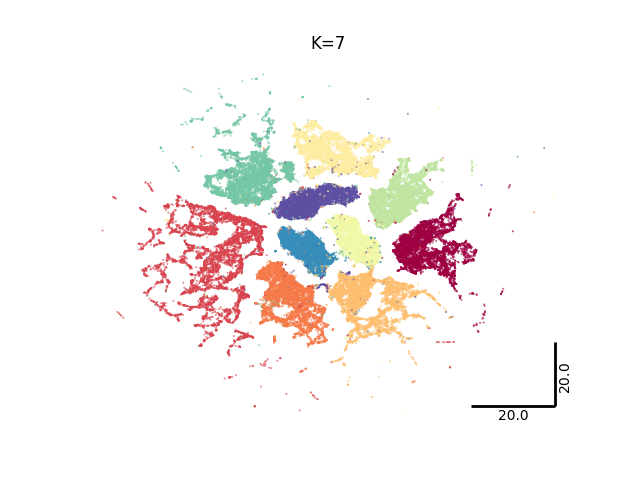

In [50]:
fig_folder = 'PaCMAP_Figs/'

with open('localmap_K_7.npy', 'rb') as f:
    umap_pca = np.load(f)
    
print(umap_pca.shape)

fig, ax = plt.subplots()

scatter = plt.scatter(umap_pca[:,0], umap_pca[:,1], c=y_train, s=0.1, alpha=1.0, cmap='Spectral')
plt.axis('off')

add_scalebar(ax, loc=4, barwidth=2)
plt.title('K=7')
plt.savefig(fig_folder+'localmap_K_7.png', dpi=400, bbox_inches='tight', pad_inches=0.4)

(60000, 2)


<IPython.core.display.Javascript object>


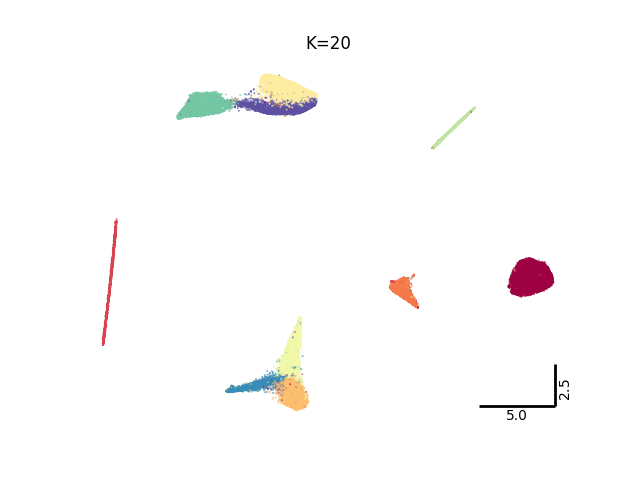

In [51]:
fig_folder = 'PaCMAP_Figs/'

with open('localmap_K_20.npy', 'rb') as f:
    umap_pca = np.load(f)
    
print(umap_pca.shape)

fig, ax = plt.subplots()

scatter = plt.scatter(umap_pca[:,0], umap_pca[:,1], c=y_train, s=0.1, alpha=1.0, cmap='Spectral')
plt.axis('off')

add_scalebar(ax, loc=4, barwidth=2)
plt.title('K=20')
plt.savefig(fig_folder+'localmap_K_20.png', dpi=400, bbox_inches='tight', pad_inches=0.4)

<IPython.core.display.Javascript object>


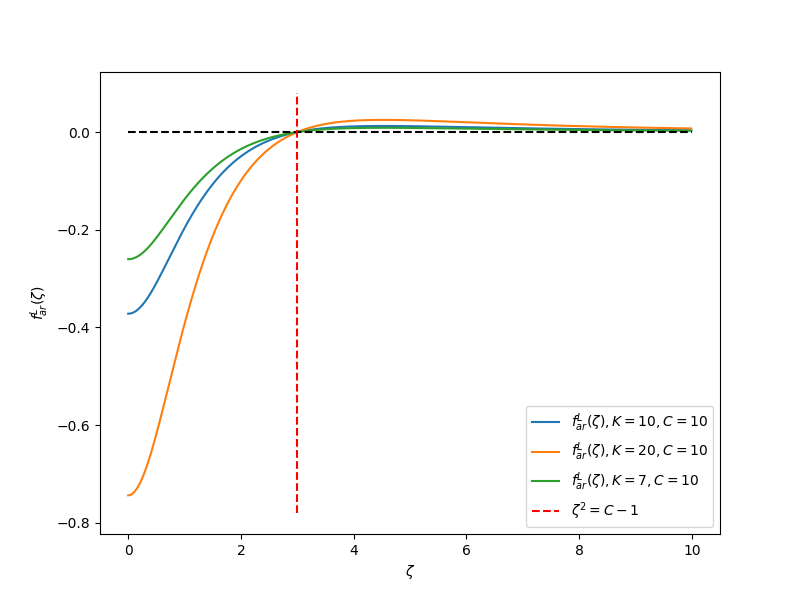

In [52]:
K = 10
C = 10
frp = lambda zeta1, K, C: - K * (C-1-zeta1**2) / (2*np.sqrt(1+zeta1**2)*(C+1+zeta1**2)**2)

zeta1 = np.arange(0,10,0.01)

plt.figure(figsize=(8,6))
fz = frp(zeta1, 10, 10)
plt.plot(zeta1, fz, label=r'$f_{ar}^L(\zeta), K=10, C=10$')
fz = frp(zeta1, 20, 10)
plt.plot(zeta1, fz, label=r'$f_{ar}^L(\zeta), K=20, C=10$')
fz = frp(zeta1, 7, 10)
plt.plot(zeta1, fz, label=r'$f_{ar}^L(\zeta), K=7, C=10$')
plt.plot([0,10],[0,0],'k--')
plt.plot([3,3],[-0.78,0.08], 'r--', label=r'$\zeta^2=C-1$')
#plt.legend()
#plt.ylim([-0.8,0.1])
plt.xlabel(r"$\zeta$")
plt.ylabel(r"$f_{ar}^L(\zeta)$")
plt.legend(loc=4)
plt.savefig(fig_folder+'atr_rep_localmap.png')